In [1]:
import numpy as np
import awkward as ak
import pandas as pd
import matplotlib.pyplot as plt

import xobjects as xo
import xtrack as xt
import xpart as xp
import xcoll as xc

# BPM class

In [2]:
from typing import Optional, Tuple, Union, Set, List
import re

class BPMBehavior(ak.Record):
    pass

class BPMCollectionBehavior(ak.Array):
    @property
    def full_index(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        return self._full_index
    
    @property
    def index(self):
        if not hasattr(self, '_index'):
            self._build_index()
        return self._index
    
    @property
    def bpms_hor(self):
        if not hasattr(self, '_bpms_hor'):
            self._build_bpms_hor()
        return self._bpms_hor
    
    @property
    def bpms_ver(self):
        if not hasattr(self, '_bpms_ver'):
            self._build_bpms_ver()
        return self._bpms_ver
    
    @property
    def hor_turn_position(self):
        if not hasattr(self, '_hor_pos'):
            self._build_hor_pos()
        return self._hor_pos
    
    @property
    def ver_turn_position(self):
        if not hasattr(self, '_ver_pos'):
            self._build_ver_pos()
        return self._ver_pos
    
    def _build_full_index(self):
        self._full_index = {}

        bpm_entries = []

        # Collect all BPMs with metadata
        for crate in self.fields:
            for i, bpm in enumerate(self[crate]['value']['channelNames'][0]):
                if bpm != 'SPARE':
                    split_bpm = bpm.split('.')
                    bpm_name = split_bpm[0].lower() + '.' + split_bpm[1]
                    plane = split_bpm[2]
                    position = self[crate]['value']['positions'][0][i]

                    bpm_entries.append({
                        'bpm_name': bpm_name,
                        'plane': plane,
                        'crate': crate,
                        'position': position
                    })

        # Sort BPMs by natural order (e.g., bpm.1, bpm.2, ..., bpm.10)
        def natural_key(entry):
            # Extract the numeric part of the BPM name for sorting
            match = re.search(r'(\d+)$', entry['bpm_name'])
            return int(match.group(1)) if match else entry['bpm_name']

        bpm_entries.sort(key=natural_key)

        # Build _full_index with sorted BPMs
        for idx, entry in enumerate(bpm_entries):
            name = entry['bpm_name']
            if name not in self._full_index:
                self._full_index[name] = {}
            self._full_index[name]['plane'] = entry['plane']
            self._full_index[name]['index'] = idx
            self._full_index[name]['crate'] = entry['crate']
            self._full_index[name]['positions'] = entry['position']
    
    def _build_index(self):
        self._index = {}
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        for i, bpm in enumerate(self._full_index):
            if bpm not in self._index:
                self._index[bpm] = i

    def _build_bpms_hor(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        bpms = [bpm for bpm in self._full_index if self._full_index[bpm]['plane'] == 'H']
        self._bpms_hor = ak.Array(sorted(bpms, key=lambda bpm: self._full_index[bpm]['index'])) #BPMs are sorted by index
    
    def _build_bpms_ver(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        bpms = [bpm for bpm in self._full_index if self._full_index[bpm]['plane'] == 'V']
        self._bpms_ver = ak.Array(sorted(bpms, key=lambda bpm: self._full_index[bpm]['index'])) #BPMs are sorted by index

    def _build_hor_pos(self):
        if not hasattr(self, '_bpms_hor'):
            self._build_bpms_hor()
        self._hor_pos = ak.Array([self._full_index[bpm]['positions'] for bpm in self._bpms_hor])
    
    def _build_ver_pos(self):
        if not hasattr(self, '_bpms_ver'):
            self._build_bpms_ver()
        self._ver_pos = ak.Array([self._full_index[bpm]['positions'] for bpm in self._bpms_ver])


ak.behavior["*", "BPMCollection"] = BPMCollectionBehavior

# Bump tests
Do I get same orbit with bump if I give in the data or if I do it myself?  
What difference in orbit do I get if I fill in the values from LSA?

In [50]:
line_ref = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta5.json')
line1 = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta5.json')
line2 = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta5.json')

Loading line from dict:   0%|          | 0/36404 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/36404 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/36404 [00:00<?, ?it/s]

Done loading line from dict.           


In [51]:
numbers = sorted([40407, 31207, 61805, 33607, 22607, 22207, 22407, 21007,
           52607, 42407, 51207, 51007, 30207, 42007, 41607])
for number in numbers:
    if number==61805:
        print(number, line_ref.ref[f'mdha.{number}'].knl[0]._value)
    else:
        print(number, line_ref.ref[f'mdh.{number}'].knl[0]._value)
print('All corrections of LSA are proper to our beam, because in standard line they are zero')

21007 -0.0
22207 -0.0
22407 -0.0
22607 -0.0
30207 -0.0
31207 -0.0
33607 -0.0
40407 -0.0
41607 -0.0
42007 -0.0
42407 -0.0
51007 -0.0
51207 -0.0
52607 -0.0
61805 0.0
All corrections of LSA are proper to our beam, because in standard line they are zero


In [52]:
#standard corrections in machine
line1['bump.21007'] = 1.2325e-5
line1['bump.22207'] = 0
line1['bump.22407'] = 0
line1['bump.22607'] = 3.0687e-5
line1['bump.30207'] = -3.56261e-5
line1['bump.31207'] = 5.85993e-5
line1['bump.33607'] = 4.168e-5
line1['bump.40407'] = 6.88864e-5
line1['bump.41607'] = -7.08518e-5
line1['bump.42007'] = -5.7098e-5
line1['bump.42407'] = -2.8743e-6
line1['bump.51007'] = -2.57878e-5
line1['bump.51207'] = 0
line1['bump.52607'] = 0
line1['bump.61805'] = 4.44586e-5
for number in numbers:
    if number==61805:
        line1.ref[f'mdha.{number}'].knl[0] += line1.vars[f'bump.{number}']
    else:
        line1.ref[f'mdh.{number}'].knl[0] += line1.vars[f'bump.{number}']

In [53]:
# tt_h_correctors = [f'mdh.{number}' for number in numbers if number != 61805]
# tt_h_correctors.append('mdha.61805')
# line1.steering_correctors_x = tt_h_correctors

# tt1 = line1.get_table()
# tt_v_correctors = tt1.rows['mdv\..*'].rows['.*v\..*']
# mask_ap_v = np.array([el.startswith('Limit') for el in tt_v_correctors.element_type])
# line1.steering_correctors_y = tt_v_correctors.name[~mask_ap_v]

# tw1 = line1.twiss()
# orbit_correction = line1.correct_trajectory(twiss_table=tw1,n_micado=5, n_iter=10)

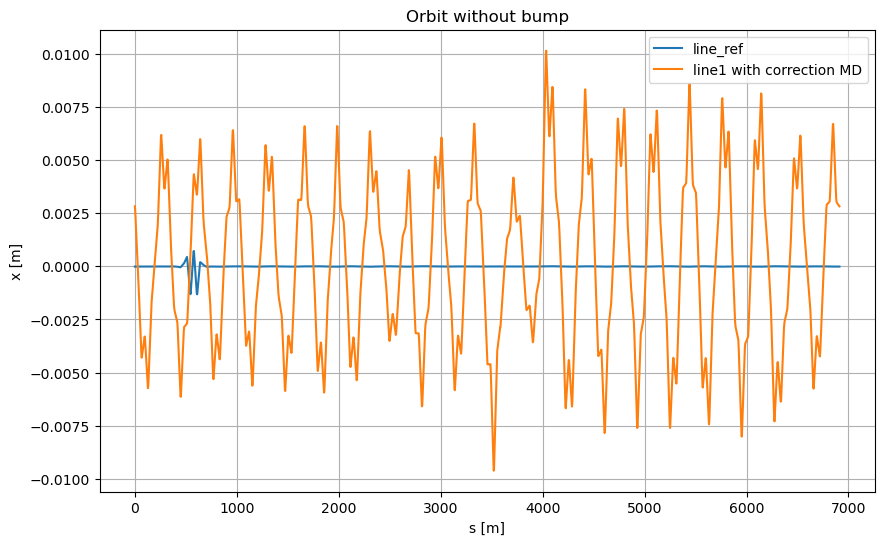

In [56]:
tw_ref = line_ref.twiss()
tw1 = line1.twiss()

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(tw_ref['s'], tw_ref['x'], label='line_ref')
ax.plot(tw1['s'], tw1['x']-tw_ref['x'], label='line1 with correction MD')
ax.set_xlabel('s [m]')
ax.set_ylabel('x [m]')
ax.grid()
ax.set_title('Orbit without bump')
ax.legend()

In [57]:
#standard corrections in machine
line2['bump.21007'] = 1.2325e-5
line2['bump.22207'] = 0
line2['bump.22407'] = 0
line2['bump.22607'] = 3.0687e-5
line2['bump.30207'] = -3.56261e-5
line2['bump.31207'] = 5.85993e-5
line2['bump.33607'] = 4.168e-5
line2['bump.40407'] = 6.88864e-5
line2['bump.41607'] = -7.08518e-5
line2['bump.42007'] = -5.7098e-5
line2['bump.42407'] = -2.8743e-6
line2['bump.51007'] = -2.57878e-5
line2['bump.51207'] = 0
line2['bump.52607'] = 0
line2['bump.61805'] = 4.44586e-5
for number in numbers:
    if number==61805:
        line2.ref[f'mdha.{number}'].knl[0] += line2.vars[f'bump.{number}']
    else:
        line2.ref[f'mdh.{number}'].knl[0] += line2.vars[f'bump.{number}']

In [58]:
#Bump
line2['bump.11207'] = -1.19603e-4
line2['bump.11407'] = 9.3027e-5
line2['bump.11607'] = -1.19603e-4

line2.ref['mdh.11207'].knl[0] += line2.vars['bump.11207']
line2.ref['mdh.11407'].knl[0] += line2.vars['bump.11407']
line2.ref['mdh.11607'].knl[0] += line2.vars['bump.11607']

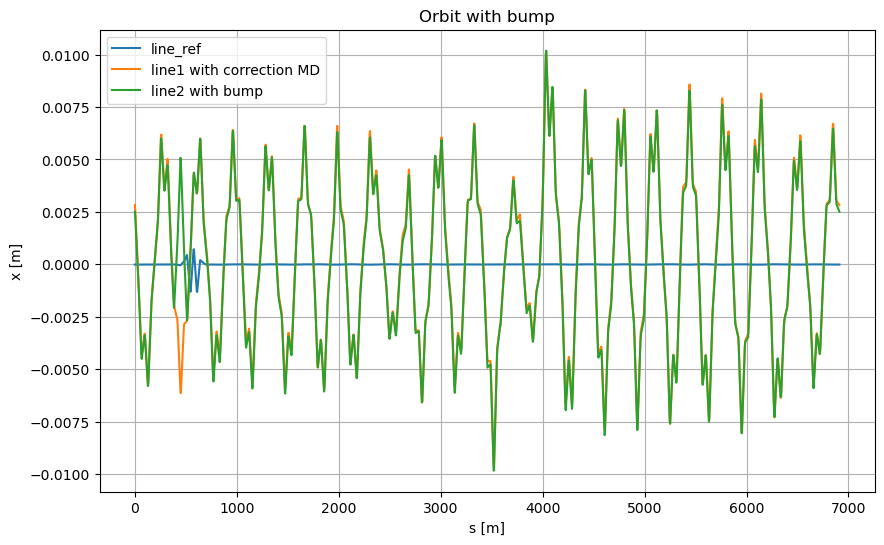

In [59]:
tw2 = line2.twiss()
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(tw_ref['s'], tw_ref['x'], label='line_ref')
ax.plot(tw1['s'], tw1['x']-tw_ref['x'], label='line1 with correction MD')
ax.plot(tw2['s'], tw2['x']-tw_ref['x'], label='line2 with bump')
ax.set_xlabel('s [m]')
ax.set_ylabel('x [m]')
ax.grid()
ax.set_title('Orbit with bump')
ax.legend()

In [64]:
line3 = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta5.json')

Loading line from dict:   0%|          | 0/36404 [00:00<?, ?it/s]

Done loading line from dict.           


In [65]:
#standard corrections in machine
line3['bump.21007'] = 1.2325e-5
line3['bump.22207'] = 0
line3['bump.22407'] = 0
line3['bump.22607'] = 3.0687e-5
line3['bump.30207'] = -3.56261e-5
line3['bump.31207'] = 5.85993e-5
line3['bump.33607'] = 4.168e-5
line3['bump.40407'] = 6.88864e-5
line3['bump.41607'] = -7.08518e-5
line3['bump.42007'] = -5.7098e-5
line3['bump.42407'] = -2.8743e-6
line3['bump.51007'] = -2.57878e-5
line3['bump.51207'] = 0
line3['bump.52607'] = 0
line3['bump.61805'] = 4.44586e-5
for number in numbers:
    if number==61805:
        line3.ref[f'mdha.{number}'].knl[0] += line3.vars[f'bump.{number}']
    else:
        line3.ref[f'mdh.{number}'].knl[0] += line3.vars[f'bump.{number}']

In [66]:
#Bump
line3['bump.11207'] = 0
line3['bump.11407'] = 0
line3['bump.11607'] = 0

line3.ref['mdh.11207'].knl[0] += line3.vars['bump.11207']
line3.ref['mdh.11407'].knl[0] += line3.vars['bump.11407']
line3.ref['mdh.11607'].knl[0] += line2.vars['bump.11607']
tw3_ref = line3.twiss()
opt = line3.match(
    solve=False,
    start='mdh.11007',
    end='mdhw.11732',
    init=tw3_ref,
    vary=[
        xt.VaryList(['bump.11207', 'bump.11407', 'bump.11607'], step=1e-8, tag='bump',)
    ],
    targets = [
        xt.Target('x', -10e-3, at='tidp.11434'),
        xt.TargetSet(['x', 'px'], value=tw3_ref, at='mdhw.11732')
    ]
    )
opt.run_jacobian(10)

                                             
Optimize - start penalty: 0.1541                            
Matching: model call n. 73 penalty = 2.6401e-02              
Optimize - end penalty:  0.026401                            


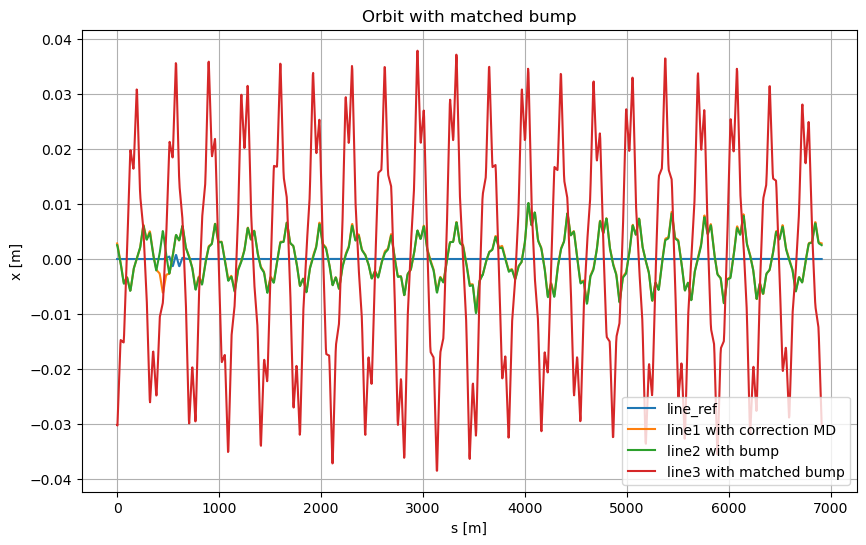

In [67]:
tw3 = line3.twiss()
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(tw_ref['s'], tw_ref['x'], label='line_ref')
ax.plot(tw1['s'], tw1['x']-tw_ref['x'], label='line1 with correction MD')
ax.plot(tw2['s'], tw2['x']-tw_ref['x'], label='line2 with bump')
ax.plot(tw3['s'], tw3['x']-tw_ref['x'], label='line3 with matched bump')
ax.set_xlabel('s [m]')
ax.set_ylabel('x [m]')
ax.grid()
ax.set_title('Orbit with matched bump')
ax.legend()

In [72]:
line4 = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta5.json')

#Bump
line4['bump.11207'] = -1.19603e-4
line4['bump.11407'] = 9.3027e-5
line4['bump.11607'] = -1.19603e-4

line4.ref['mdh.11207'].knl[0] += line4.vars['bump.11207']
line4.ref['mdh.11407'].knl[0] += line4.vars['bump.11407']
line4.ref['mdh.11607'].knl[0] += line4.vars['bump.11607']
tw4 = line4.twiss()

Loading line from dict:   0%|          | 0/36404 [00:00<?, ?it/s]

Done loading line from dict.           


In [71]:
line5 = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta5.json')
#Bump
line5['bump.11207'] = 0
line5['bump.11407'] = 0
line5['bump.11607'] = 0

line5.ref['mdh.11207'].knl[0] += line5.vars['bump.11207']
line5.ref['mdh.11407'].knl[0] += line5.vars['bump.11407']
line5.ref['mdh.11607'].knl[0] += line5.vars['bump.11607']

tw5_ref = line5.twiss()
opt = line5.match(
    solve=False,
    start='mdh.11007',
    end='mdhw.11732',
    init=tw3_ref,
    vary=[
        xt.VaryList(['bump.11207', 'bump.11407', 'bump.11607'], step=1e-8, tag='bump',)
    ],
    targets = [
        xt.Target('x', -10e-3, at='tidp.11434'),
        xt.TargetSet(['x', 'px'], value=tw3_ref, at='mdhw.11732')
    ]
    )
opt.run_jacobian(10)
tw5 = line5.twiss()

Loading line from dict:   0%|          | 0/36404 [00:00<?, ?it/s]

Done loading line from dict.           
                                             
Optimize - start penalty: 0.1625                            
Matching: model call n. 11 penalty = 8.5967e-09              
Optimize - end penalty:  8.59667e-09                            


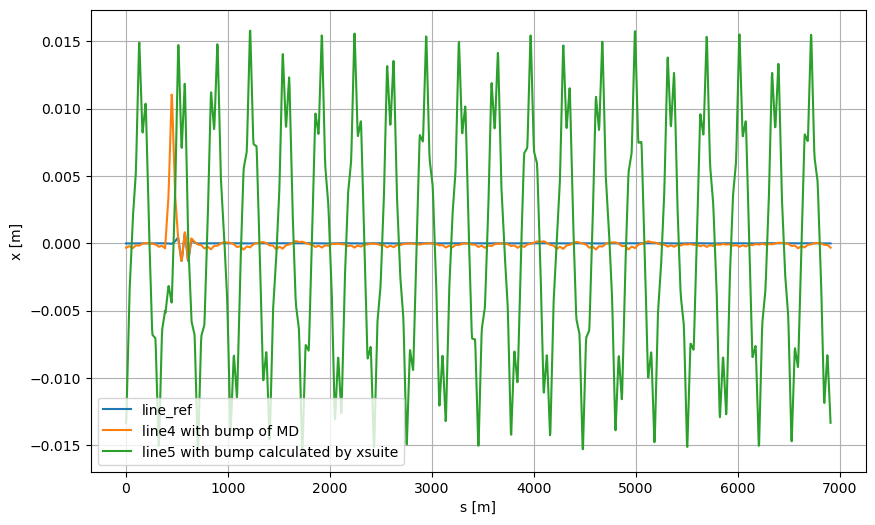

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(tw_ref.s, tw_ref.x, label='line_ref')
ax.plot(tw4.s, tw4.x, label='line4 with bump of MD')
ax.plot(tw5.s, tw5.x, label='line5 with bump calculated by xsuite')
ax.set_xlabel('s [m]')
ax.set_ylabel('x [m]')
ax.grid()
ax.legend()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(tw_ref['s'], tw_ref['x'], label='line_ref')
ax.plot(tw2.s, tw2.x, label='line3 with bump and correction MD')
ax.plot(tw4.s, tw4.x, label='line5 with bump and correction MD')

!!!! sps_with_aperture_inj_q20_beam_sagitta5.json has a problem, cannot get a closed bump !!

In [122]:
line_Frederik = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta3.json')
line_Frederik2 = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')
line_Frederik3 = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta5.json')

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/36395 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/36404 [00:00<?, ?it/s]

Done loading line from dict.           


In [123]:
tw_Frederik_ref = line_Frederik.twiss()
line_Frederik['bump.11207'] = 0
line_Frederik['bump.11407'] = 0
line_Frederik['bump.11607'] = 0

line_Frederik.ref['mdh.11207'].knl[0] += line_Frederik.vars['bump.11207']
line_Frederik.ref['mdh.11407'].knl[0] += line_Frederik.vars['bump.11407']
line_Frederik.ref['mdh.11607'].knl[0] += line_Frederik.vars['bump.11607']

opt = line_Frederik.match(
    solve=False,
    start='mdh.11007',
    end='mdhw.11732',
    init=tw_Frederik_ref,
    vary=[
        xt.VaryList(['bump.11207', 'bump.11407', 'bump.11607'], step=1e-8, tag='bump',)
    ],
    targets = [
        xt.Target('x', -10e-3, at='tidp.11434..1'),
        xt.TargetSet(['x', 'px'], value=tw_Frederik_ref, at='mdhw.11732')
    ]
    )
opt.run_jacobian(10)
tw_Frederik = line_Frederik.twiss()

                                             
Optimize - start penalty: 0.09987                           
Matching: model call n. 11 penalty = 1.8881e-09              
Optimize - end penalty:  1.88806e-09                            


In [124]:
line_Frederik2['bump.11207'] = 0
line_Frederik2['bump.11407'] = 0
line_Frederik2['bump.11607'] = 0

line_Frederik2.ref['mdh.11207'].knl[0] += line_Frederik2.vars['bump.11207']
line_Frederik2.ref['mdh.11407'].knl[0] += line_Frederik2.vars['bump.11407']
line_Frederik2.ref['mdh.11607'].knl[0] += line_Frederik2.vars['bump.11607']

opt = line_Frederik2.match(
    solve=False,
    start='mdh.11007',
    end='mdhw.11732',
    init=tw_Frederik_ref,
    vary=[
        xt.VaryList(['bump.11207', 'bump.11407', 'bump.11607'], step=1e-8, tag='bump',)
    ],
    targets = [
        xt.Target('x', -10e-3, at='tidp.11434'),
        xt.TargetSet(['x', 'px'], value=tw_Frederik_ref, at='mdhw.11732')
    ]
    )
opt.run_jacobian(10)
tw_Frederik2 = line_Frederik2.twiss()

                                             
Optimize - start penalty: 0.09975                           
Matching: model call n. 11 penalty = 1.5346e-09              
Optimize - end penalty:  1.53457e-09                            


In [125]:
line_Frederik3['bump.11207'] = 0
line_Frederik3['bump.11407'] = 0
line_Frederik3['bump.11607'] = 0

line_Frederik3.ref['mdh.11207'].knl[0] += line_Frederik3.vars['bump.11207']
line_Frederik3.ref['mdh.11407'].knl[0] += line_Frederik3.vars['bump.11407']
line_Frederik3.ref['mdh.11607'].knl[0] += line_Frederik3.vars['bump.11607']

opt = line_Frederik3.match(
    solve=False,
    start='mdh.11007',
    end='mdhw.11732',
    init=tw_Frederik_ref,
    vary=[
        xt.VaryList(['bump.11207', 'bump.11407', 'bump.11607'], step=1e-8, tag='bump',)
    ],
    targets = [
        xt.Target('x', -10e-3, at='tidp.11434'),
        xt.TargetSet(['x', 'px'], value=tw_Frederik_ref, at='mdhw.11732')
    ]
    )
opt.run_jacobian(10)
tw_Frederik3 = line_Frederik3.twiss()

                                             
Optimize - start penalty: 0.09975                           
Matching: model call n. 11 penalty = 1.5346e-09              
Optimize - end penalty:  1.53457e-09                            


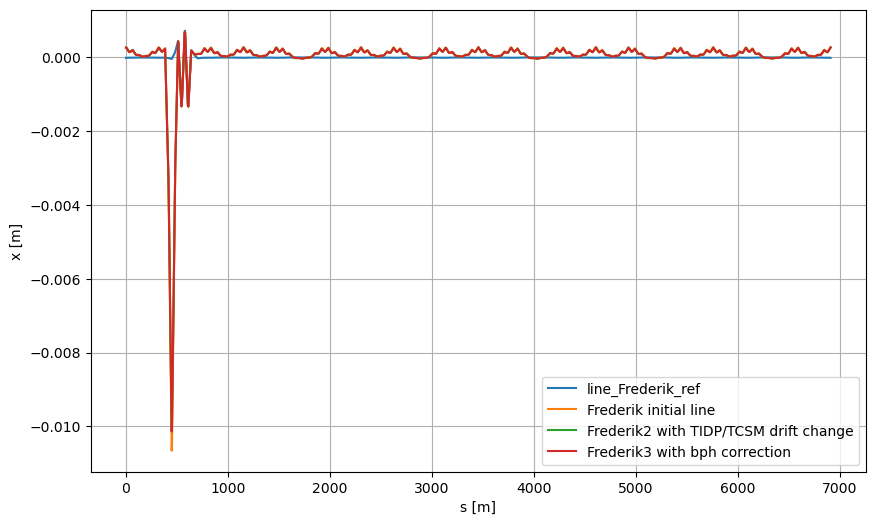

In [128]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(tw_Frederik_ref.s, tw_Frederik_ref.x, label='line_Frederik_ref')
ax.plot(tw_Frederik.s, tw_Frederik.x, label='Frederik initial line')
ax.plot(tw_Frederik2.s, tw_Frederik2.x, label='Frederik2 with TIDP/TCSM drift change')
ax.plot(tw_Frederik3.s, tw_Frederik3.x, label='Frederik3 with bph correction')
ax.set_xlabel('s [m]')
ax.set_ylabel('x [m]')
ax.grid()
ax.legend()

There does not seem to be a problem anymore? Where does the issue come from?

# Clean

line ref is the reference line, with no problem.  
line 1 is reference line with -10mm bump calculated by xsuite and 4d ref.
line 2 is reference line with -10mm bump calculated by xsuite and 6d ref 
line 3 is reference line with -10mm bump from MD.  
line 4 is orbit correction from MD.  
line 5 is orbit correction from MD and -10mm bump from MD.  
line 6 is orbit correction from MD and -10mm bump calculated by xsuite.  

In [129]:
line_ref = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta5.json')
line1 = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta5.json')
line2 = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta5.json')
line3 = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta5.json')
line4 = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta5.json')
line5 = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta5.json')
line6 = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta5.json')

Loading line from dict:   0%|          | 0/36404 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/36404 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/36404 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/36404 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/36404 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/36404 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/36404 [00:00<?, ?it/s]

Done loading line from dict.           


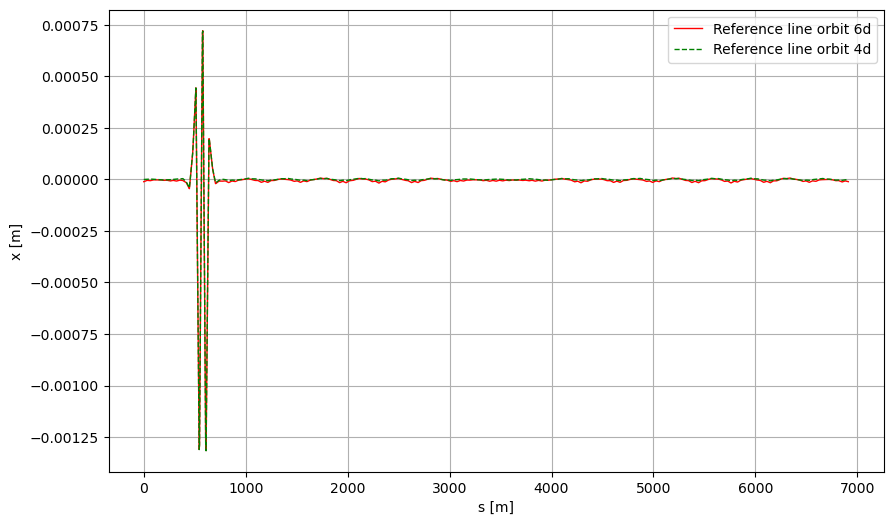

In [267]:
#Reference line
tw_ref = line_ref.twiss()
tw_ref4d = line_ref.twiss4d()

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(tw_ref.s, tw_ref.x, label='Reference line orbit 6d', color='red', lw=1)
ax.plot(tw_ref4d.s, tw_ref4d.x, label='Reference line orbit 4d', color='green', ls ='--', lw=1)
ax.set_xlabel('s [m]')
ax.set_ylabel('x [m]')
ax.grid()
ax.legend()

In [131]:
#Line 1 and 2 with -10mm bump calculated by xsuite, 4d and 6d ref
#Line 1
line1['bump.11207'] = 0
line1['bump.11407'] = 0
line1['bump.11607'] = 0

line1.ref['mdh.11207'].knl[0] += line1.vars['bump.11207']
line1.ref['mdh.11407'].knl[0] += line1.vars['bump.11407']
line1.ref['mdh.11607'].knl[0] += line1.vars['bump.11607']

opt = line1.match(
    solve=False,
    start='mdh.11007',
    end='mdhw.11732',
    init=tw_ref4d,
    vary=[
        xt.VaryList(['bump.11207', 'bump.11407', 'bump.11607'], step=1e-8, tag='bump',)
    ],
    targets = [
        xt.Target('x', -10e-3, at='tidp.11434'),
        xt.TargetSet(['x', 'px'], value=tw_ref4d, at='mdhw.11732')
    ]
    )
opt.run_jacobian(10)
tw1 = line1.twiss()

#Line 2
line2['bump.11207'] = 0
line2['bump.11407'] = 0
line2['bump.11607'] = 0

line2.ref['mdh.11207'].knl[0] += line2.vars['bump.11207']
line2.ref['mdh.11407'].knl[0] += line2.vars['bump.11407']
line2.ref['mdh.11607'].knl[0] += line2.vars['bump.11607']

opt = line2.match(
    solve=False,
    start='mdh.11007',
    end='mdhw.11732',
    init=tw_ref,
    vary=[
        xt.VaryList(['bump.11207', 'bump.11407', 'bump.11607'], step=1e-8, tag='bump',)
    ],
    targets = [
        xt.Target('x', -10e-3, at='tidp.11434'),
        xt.TargetSet(['x', 'px'], value=tw_ref, at='mdhw.11732')
    ]
    )
opt.run_jacobian(10)
tw2 = line2.twiss()

                                             
Optimize - start penalty: 0.09978                           
Matching: model call n. 11 penalty = 1.5364e-09              
Optimize - end penalty:  1.53635e-09                            
                                             
Optimize - start penalty: 0.09974                           
Matching: model call n. 11 penalty = 1.5340e-09              
Optimize - end penalty:  1.53401e-09                            


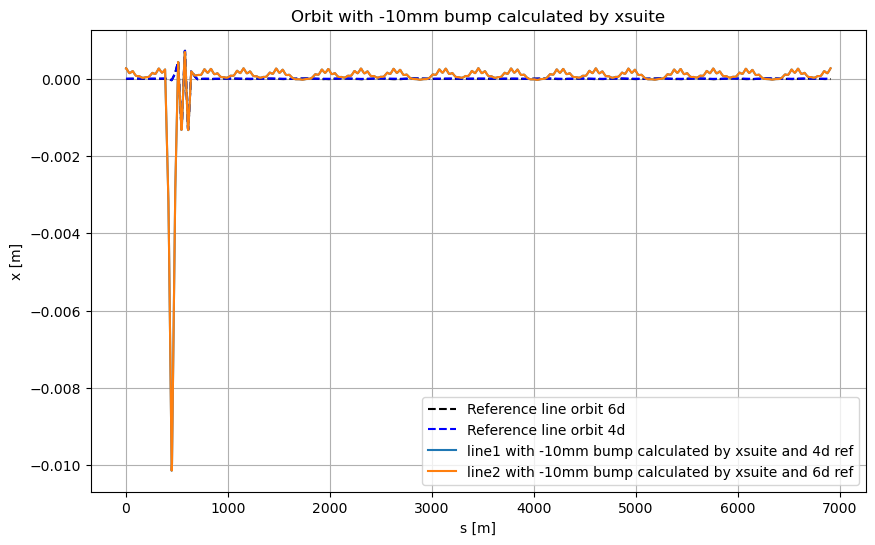

In [135]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(tw_ref.s, tw_ref.x, 'k--', label='Reference line orbit 6d')
ax.plot(tw_ref4d.s, tw_ref4d.x, 'b--', label='Reference line orbit 4d')
ax.plot(tw1.s, tw1.x, label='line1 with -10mm bump calculated by xsuite and 4d ref')
ax.plot(tw2.s, tw2.x, label='line2 with -10mm bump calculated by xsuite and 6d ref')
ax.set_xlabel('s [m]')
ax.set_ylabel('x [m]')
ax.grid()
ax.set_title('Orbit with -10mm bump calculated by xsuite')
ax.legend()

No difference when giving 4d or 6d twiss as reference !!

In [269]:
# Line 3 
line3 = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta5.json')
line3['bump.11207'] = 1.19603e-4
line3['bump.11407'] = -9.3027e-5
line3['bump.11607'] = 1.19603e-4

line3.ref['mdh.11207'].knl[0] += line3.vars['bump.11207']
line3.ref['mdh.11407'].knl[0] += line3.vars['bump.11407']
line3.ref['mdh.11607'].knl[0] += line3.vars['bump.11607']

tw3 = line3.twiss()

Loading line from dict:   0%|          | 0/36404 [00:00<?, ?it/s]

Done loading line from dict.           


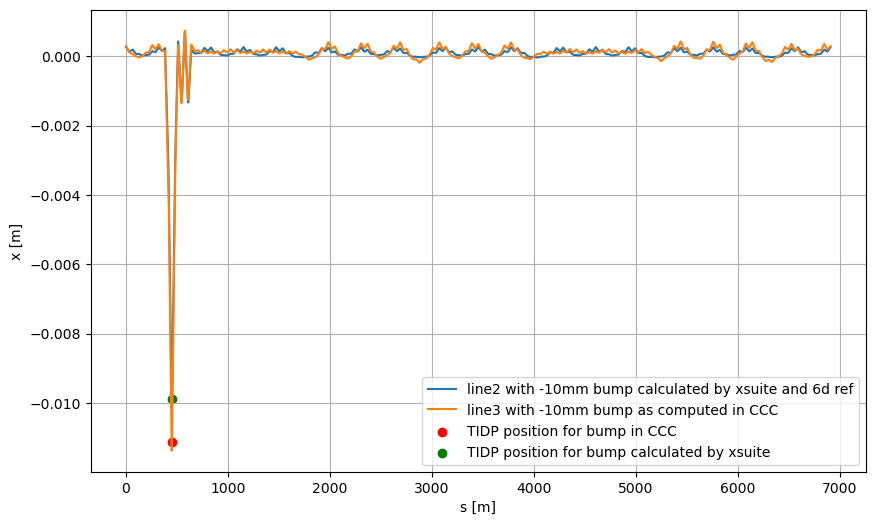

In [279]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(tw2.s, tw2.x, label='line2 with -10mm bump calculated by xsuite and 6d ref')
ax.plot(tw3.s, tw3.x, label='line3 with -10mm bump as computed in CCC')
ax.scatter(tw3.s[tw3.name=='tidp.11434'], tw3.x[tw3.name=='tidp.11434'], color='red', label='TIDP position for bump in CCC')
ax.scatter(tw2.s[tw2.name=='tidp.11434'], tw2.x[tw2.name=='tidp.11434'], color='green', label='TIDP position for bump calculated by xsuite')
ax.set_xlabel('s [m]')
ax.set_ylabel('x [m]')
ax.grid()
ax.legend()

In [272]:
print(line3.ref['mdh.11207'].knl[0]._value, line3.ref['mdh.11407'].knl[0]._value, line3.ref['mdh.11607'].knl[0]._value)

0.00012002975179479781 -9.813920728448744e-05 0.00017208773409290134


In [274]:
print(line2.ref['mdh.11207'].knl[0]._value, line2.ref['mdh.11407'].knl[0]._value, line2.ref['mdh.11607'].knl[0]._value)

0.000108209383171967 -8.987372411437858e-05 0.00016024148598351904


In [282]:
np.min(tw3.x), np.argmin(tw3.x)

(np.float64(-0.011381212680745822), np.int64(2154))

In [284]:
line3.element_names[2154]

'qf.11410'

In [290]:
line3['veqf.11410.a_aper']

View of LimitEllipse(a=0.076, b=0.0208)

Two conclusions:
- CCC calculation is overshooting the bump by approximately -1.5mm 
- As expected, this bump configuration cannot produce the maximum bump at the TIDP, it will reach in qf.11410. Given the aperture, you would already need a very big bump before reaching it. It also means that this is not the aperture we are looking for in the search for the overtaking aperture from MD

In [ ]:
#Line4: orbit correction MD
line4['bump.21007'] = 1.2325e-5
line4['bump.22207'] = 0
line4['bump.22407'] = 0
line4['bump.22607'] = 3.0687e-5
line4['bump.30207'] = -3.56261e-5
line4['bump.31207'] = 5.85993e-5
line4['bump.33607'] = 4.168e-5
line4['bump.40407'] = 6.88864e-5
line4['bump.41607'] = -7.08518e-5
line4['bump.42007'] = -5.7098e-5
line4['bump.42407'] = -2.8743e-6
line4['bump.51007'] = -2.57878e-5
line4['bump.51207'] = 0
line4['bump.52607'] = 0
line4['bump.61805'] = 4.44586e-5
for number in numbers:
    if number==61805:
        line4.ref[f'mdha.{number}'].knl[0] += line4.vars[f'bump.{number}']
    else:
        line4.ref[f'mdh.{number}'].knl[0] += line4.vars[f'bump.{number}']
tw4 = line4.twiss()

In [308]:
line_without_correction = xt.Line.from_json('../../injection_lines/injection_thin_approx_ap_with_deferred_expressions.json')

#Set cavitiy voltages correctly
line_without_correction['acl.31735'].frequency = 800e6
line_without_correction['acl.31735'].voltage = 2 * 0.18e6
line_without_correction['acl.31735'].lag = 180

line_without_correction['actcse.31632'].frequency = 200e6
line_without_correction['actcse.31632'].voltage = 4.5e6
line_without_correction['actcse.31632'].lag = 180

tw_wc_before = line_without_correction.twiss4d()

env = line_without_correction.env
for name in line_without_correction.element_names:
    if line_without_correction[name].__class__.__name__.startswith('Limit') or line_without_correction[name].__class__.__name__.startswith('Multipole'):
        #Dogleg in LSS5 for extraction
        if 'qd.51710' in name:
            line_without_correction[name].shift_y = -5.273e-3
        elif 'qfa.51810' in name:
            line_without_correction[name].shift_y = -17.369e-3
        elif 'qd.51910' in name:
            line_without_correction[name].shift_y = -5.273e-3
        #Dogleg in LSS1 for injection
        elif 'qda.11710' in name:
            line_without_correction[name].shift_x = -4.80e-3
        elif 'qfa.11810' in name:
            line_without_correction[name].shift_x = -2.97e-3
        elif 'qda.11910' in name:
            line_without_correction[name].shift_x = -4.80e-3
    
    elif line_without_correction[name].__class__.__name__.startswith('ThinSliceQuadrupole'):
        line_without_correction['qd.51710'].shift_y = -5.273e-3
        line_without_correction['qfa.51810'].shift_y = -17.369e-3
        line_without_correction['qd.51910'].shift_y = -5.273e-3
        line_without_correction['qd.11710'].shift_x = -4.80e-3
        line_without_correction['qf.11810'].shift_x = -2.97e-3
        line_without_correction['qda.11910'].shift_x = -4.80e-3


tt = line_without_correction.get_table()
tw_without_correction = line_without_correction.twiss()

Loading line from dict:   0%|          | 0/31362 [00:00<?, ?it/s]

Done loading line from dict.           


In [314]:
line_without_correction['bump.21007'] = 1.2325e-5
line_without_correction['bump.22207'] = 0
line_without_correction['bump.22407'] = 0
line_without_correction['bump.22607'] = 3.0687e-5
line_without_correction['bump.30207'] = -3.56261e-5
line_without_correction['bump.31207'] = 5.85993e-5
line_without_correction['bump.33607'] = 4.168e-5
line_without_correction['bump.40407'] = 6.88864e-5
line_without_correction['bump.41607'] = -7.08518e-5
line_without_correction['bump.42007'] = -5.7098e-5
line_without_correction['bump.42407'] = -2.8743e-6
line_without_correction['bump.51007'] = -2.57878e-5
line_without_correction['bump.51207'] = 0
line_without_correction['bump.52607'] = 0
line_without_correction['bump.61805'] = 4.44586e-5
for number in numbers:
    if number==61805:
        pass#line_without_correction.ref[f'mdha.{number}'].knl[0] += line_without_correction.vars[f'bump.{number}']
    else:
        line_without_correction.ref[f'mdh.{number}'].knl[0] += line_without_correction.vars[f'bump.{number}']
tw_without_correction_after = line_without_correction.twiss()

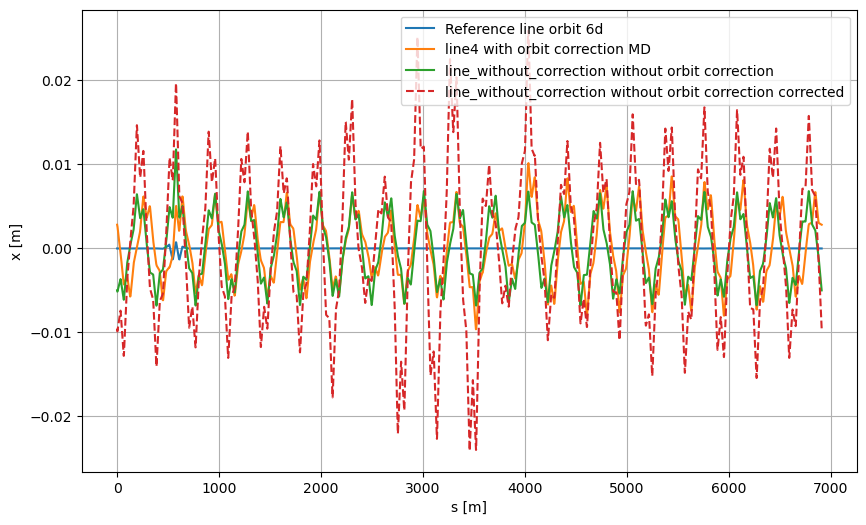

In [315]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(tw_ref.s, tw_ref.x, label='Reference line orbit 6d')
ax.plot(tw4.s, tw4.x, label='line4 with orbit correction MD')
ax.plot(tw_without_correction.s, tw_without_correction.x, label='line_without_correction without orbit correction')
ax.plot(tw_without_correction_after.s, tw_without_correction_after.x, ls = '--', label='line_without_correction without orbit correction corrected')
ax.set_xlabel('s [m]')
ax.set_ylabel('x [m]')
ax.grid()
ax.legend()

So probably not a good idea to use corrections of MD in simulation because it is not a reproduction of what happens in the machine I would say...

# Effect of the injection bump

Dora asked if I observed a negative off-momentum effect in the twiss (particle supposedly on closed orbit). This is the case. After brainstorming, it was concluded that bumps could have an effect because:
$$ x = Acos(..) + \delta D$$

Addition of bumps will change the x compared to on-momentum particle ($\delta = 0$), which will induce a delta shift.

I guess that the injection bump when freezing the delta component (twiss4d) affects the closed orbit differently than when 6d twiss. This effect results, up to a scaling factor, to the dispersion, hence a delta influence...

In [197]:
line_without_injection_bump = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20.json')
line_with_injection_bump = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta5.json')

Loading line from dict:   0%|          | 0/17781 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/36404 [00:00<?, ?it/s]

Done loading line from dict.           


In [198]:
tw6d = line_with_injection_bump.twiss()
tw4d = line_with_injection_bump.twiss4d()
tw_ini6d = line_without_injection_bump.twiss()
tw_ini4d = line_without_injection_bump.twiss4d()    

(-0.00025, 0.00025)

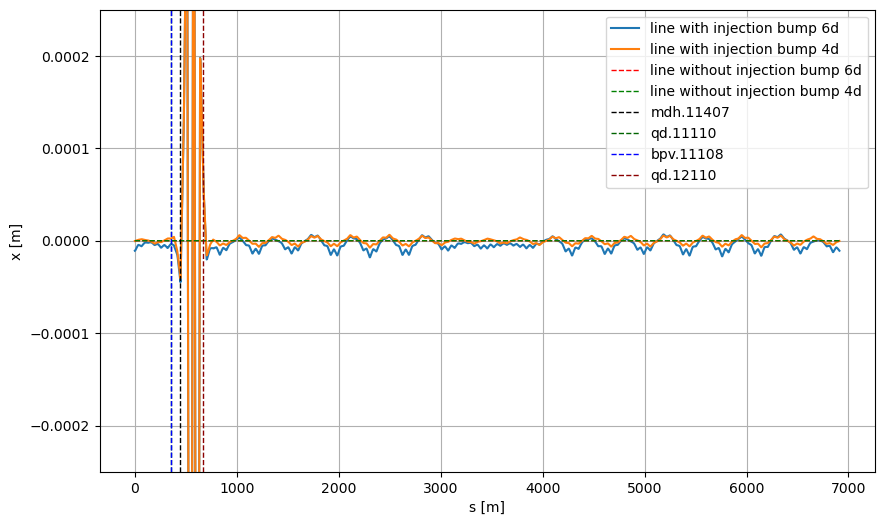

In [243]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(tw6d.s, tw6d.x, label='line with injection bump 6d')
ax.plot(tw4d.s, tw4d.x, label='line with injection bump 4d')
ax.plot(tw_ini6d.s, tw_ini6d.x, label='line without injection bump 6d', color='red', ls='--', lw=1)
ax.plot(tw_ini4d.s, tw_ini4d.x, label='line without injection bump 4d', color='green', ls='--', lw=1)

ax.vlines(447.448, -0.00025, 0.00025, color='black', ls='--', lw=1, label='mdh.11407')
ax.vlines(line.get_s_position('qd.11110'), -0.00025, 0.00025, color='darkgreen', ls='--', lw=1, label='qd.11110')
ax.vlines(line.get_s_position('bpv.11108..1'), -0.00025, 0.00025, color='blue', ls='--', lw=1, label='bpv.11108') #interesting loss location from bpt/flanges
#ax.vlines(line.get_s_position('bpv.12108..1'), -0.00025, 0.00025, color='darkred', ls='--', lw=1, label='bpv.12108') #interesting loss location from bpt/flanges (++)
ax.vlines(line.get_s_position('qd.12110'), -0.00025, 0.00025, color='darkred', ls='--', lw=1, label='qd.12110')
ax.set_xlabel('s [m]')
ax.set_ylabel('x [m]')
ax.grid()
ax.legend()
ax.set_ylim(-0.00025, 0.00025)

Here we clearly see that the injection bump introduces a closed orbit oscillation (as was already expected) but the shift between 4d/6d is clearly visible...

In [209]:
np.mean(tw6d.x[tw6d.s>1000]), np.mean(tw4d.x[tw4d.s>1000]), np.mean(tw_ini6d.x), np.mean(tw_ini4d.x)

(np.float64(-4.471310876409164e-06),
 np.float64(-3.2043732595838746e-07),
 np.float64(-4.5058572809574156e-14),
 np.float64(-2.632502319958979e-14))

Confirmation that bump shifts the orbit negatively, and more so if 6d

In [223]:
np.min(tw6d.x[tw6d.s<451.49]), np.argmin(tw6d.x[tw6d.s<451.49]), np.min(tw4d.x[tw4d.s<500]), np.argmin(tw4d.x[tw4d.s<500])

(np.float64(-4.487740582706313e-05),
 np.int64(2141),
 np.float64(-4.065998335521676e-05),
 np.int64(2141))

In [226]:
tw6d.name[tw6d.s<451.49][2141]

'mdh.11407'

In [231]:
line['mdh.11407.a_aper']

View of LimitRect(min_x=-0.076, max_x=0.076, min_y=-0.0176, max_y=0.0176, _sin_rot_s=-999, _cos_rot_s=-999, _shift_x=0, _shift_y=0, _shift_s=0)

mdh.11407 is a local minimum in the orbit (the minimum excluding the bump position), at -4.5e-5m so 40 \micro m, but aperture is of 0.076 so no impact (as predicted for q20 by bpt)

Plot shows a shift of an order of 10 of difference towards negative x compared to a non-dispersive orbit (4d). If plotting the difference between the two compared to dispersion, very good match which explains the difference in shift. So conclusion is that bump introduces a shift that is enhanced by off-momentum, but not completely explained by it...

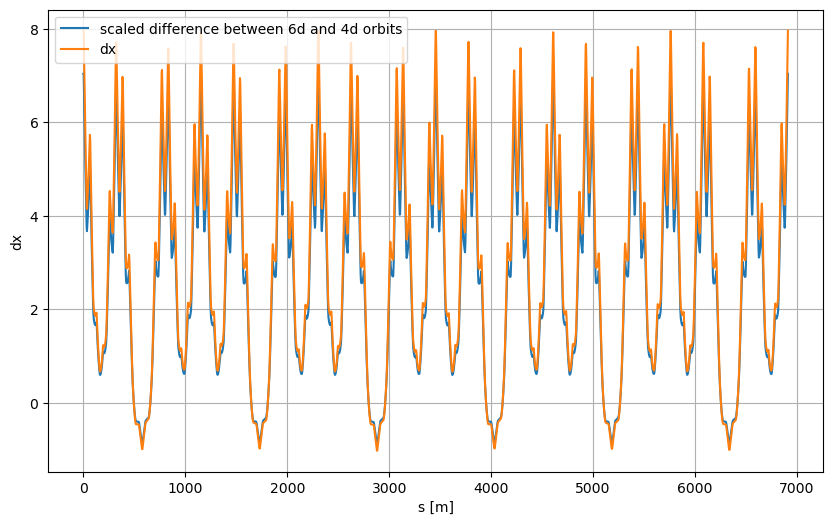

In [246]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(tw6d.s, (tw6d.x - tw4d.x)*-1e6*2/3, label='scaled difference between 6d and 4d orbits')
ax.plot(tw6d.s, tw6d.dx, label='dx')
ax.set_xlabel('s [m]')
ax.set_ylabel('dx')
ax.grid()
ax.legend()

This confirms that the difference between 4d and 6d twiss is mainly dispersion, because it scales with the dispersion factor

(-0.00025, 0.00025)

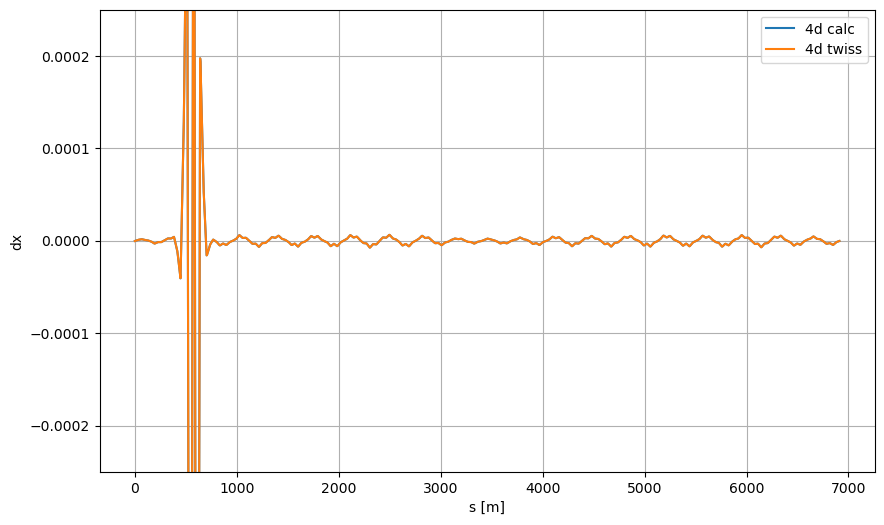

In [266]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(tw6d.s, tw6d.x - tw6d.delta*tw6d.dx, label='4d calc')
ax.plot(tw4d.s, tw4d.x, label='4d twiss')
# ax.plot(tw6d.s, tw6d.dx, label='dx')
ax.set_xlabel('s [m]')
ax.set_ylabel('dx')
ax.grid()
ax.legend()
ax.set_ylim(-0.00025, 0.00025)

Shows again 4d twiss is without off-momentum, mainly delta influence. Very small oscillation, but symmetric, so closed orbit is as good as zero

# Xsuite off-momentum delta twiss

In [317]:
line = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta5.json')
line['bump.11207'] = 1.19603e-4
line['bump.11407'] = -9.3027e-5
line['bump.11607'] = 1.19603e-4

line.ref['mdh.11207'].knl[0] += line.vars['bump.11207']
line.ref['mdh.11407'].knl[0] += line.vars['bump.11407']
line.ref['mdh.11607'].knl[0] += line.vars['bump.11607']

tw = line.twiss()

Loading line from dict:   0%|          | 0/36404 [00:00<?, ?it/s]

Done loading line from dict.           


In [327]:
tw = line.twiss()
gamma0 = line.particle_ref.gamma0
beta0 = line.particle_ref.beta0
L = line.get_length()

def sweep(line, dR):
    gtr = 1/np.sqrt(tw.momentum_compaction_factor)
    res  = (1 - gamma0**2 / gtr**2) * dR
    res -= 2 * gamma0**2 * beta0**2 / L * dR**2
    res -= beta0**2 * gamma0**2*gtr**2/L**2 * dR**3
    cav, _ = line.get_elements_of_type(xt.Cavity)
    freq = cav[0].frequency
    return res * freq / L * 2 * np.pi 

def get_df(line, dR):
    tw = line.twiss()
    gamma0 = line.particle_ref.gamma0
    beta0 = line.particle_ref.beta0
    L = line.get_length()
    gtr = 1/np.sqrt(tw.momentum_compaction_factor)
    res  = (1 - gamma0**2 / gtr**2) * dR
    res -= 2 * gamma0**2 * beta0**2 / L * dR**2
    res -= beta0**2 * gamma0**2*gtr**2/L**2 * dR**3
    return res

def get_delta(line, dR):
    df = get_df(line, dR)
    cav, _ = line.get_elements_of_type(xt.Cavity)
    freq = cav[0].frequency
    eta = line.twiss().momentum_compaction_factor
    return -1/eta *df/freq


In [331]:
delta = get_delta(line, -22e-3)

In [330]:
get_df(line, -22e-3)

LinkedArrayCpu([0.03006791])

In [332]:
delta

LinkedArrayCpu([-4.84414053e-08])

In [342]:
tw_offmomentum = line.twiss(delta0=-5.84414053e-03)

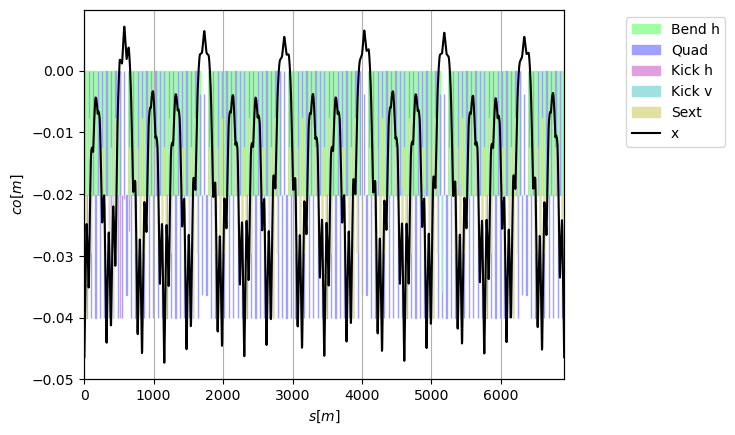

In [343]:
tw_offmomentum.plot('x')